In [1]:
from simpy.data import get_files_in_traverse_dir
from simpy.struct import SimInfo

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams.update({'font.size': 16})
plt.rc('text.latex', preamble=r'\usepackage{xfrac}')

from scipy.interpolate import interp1d

In [2]:
R = None
psi_s = None
rho_b = None
rho_R = None
n = None
N_grid = None

In [59]:
def transform_chi(chi):
    return psi_s*(1-chi)
    
def chi_B(delta):
    chi = pow(1+delta, 1/(n-1))
    return transform_chi(chi)

def upd_param(out_dir='/home/vrastil/Documents/GIT/Adhesion-Approximation/output/test_runs/test_ChiSolver/'):
    SI = SimInfo(out_dir + 'sim_param.json')
    global R, rho_b, rho_R, psi_s, n, N_grid
    R = SI.test_opt["R_sphere"]
    rho_b = SI.test_opt["rho_b"]
    rho_R = SI.test_opt["rho_sphere"]
    psi_s = SI.chi_opt["phi"]
    n = SI.chi_opt["n"]
    N_grid = SI.test_opt["N_grid"]
    
def sort_r_a(r, a):
    # sort
    p = r.argsort()
    r = r[p]
    a = a[p]
    
    # unique indices of r
    _, idx = np.unique(r, return_index=True)
    
    # if last element is unique
    if len(r) == idx[-1] + 1:
        a_last = a[-1]
        r = r[idx]
        idx = idx[:-1]
    else:
        a_last = None
        r = r[idx]
    
    # if first element is unique
    if idx[0] + 1 == idx[1]:
        a_ = [a[0]]
        idx = idx[1:]
    else:
        a_ = []
        
    # go through indices
    for i in idx:
        a_.append((a[i] + a[i+1])/2)
    
    if a_last is not None:
        a_.append(a_last)
        
    # get unique a
    a = np.array(a_)
    
    return r, a

def load_chi(out_dir='/home/vrastil/Documents/GIT/Adhesion-Approximation/output/test_runs/test_ChiSolver/'):
    upd_param(out_dir)
    
    # get files
    files = get_files_in_traverse_dir(out_dir, '*istep*')
    
    # load gravitational potential
    r, pot = sort_r_a(*np.loadtxt(out_dir + 'grav_pot.dat', unpack=True))
    
    # load chi potential
    chi_all = {}
    for a_file in files:
        istep = int(a_file[a_file.index('istep_') + len('istep_'):-4])
        r, chi = sort_r_a(*np.loadtxt(a_file, unpack=True))
        chi *= psi_s # compensate for chameleon additional factor
        chi_all[istep] = chi
        
    return r, pot, chi_all
    
def chi_supp(r, pot):
    # continuous phi
    phi = interp1d(r, pot, kind='cubic')
    
    # psi_s to phi_G at R
    supp_psi = -psi_s / phi(1) if R else -psi_s / phi(0)
    supp_psi = 1 if supp_psi > 1 else supp_psi
    
    # chi_B to phi_G at R
    supp_R = -chi_B(rho_R) / phi(1) if R else -chi_B(rho_R) / phi(0)
    supp_R = 1 if supp_R > 1 else supp_R
    
    # chi_B to phi_G at inf
    supp_inf = -chi_B(rho_b) / pot[-1]
    
    # background value at infty?
    supp_inf_eq = -transform_chi(1-rho_b/(1-n)) / pot[-1]
    plt.axhline(y=supp_inf_eq, color='g', linestyle='--', label=r'$?\chi_\infty$')
    
    return supp_psi, supp_R, supp_inf, supp_inf_eq

def plot_chi(r_, pot, chi_all,
             out_dir='/home/vrastil/Documents/GIT/Adhesion-Approximation/output/test_runs/test_ChiSolver/'):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    
    if R == 0:
        r = r_
        r_lin = N_grid/2.83
        plt.xlabel(r"$r$")   
    else:
        r = r_ / R
        r_lin = N_grid/2.83/R
        plt.xlabel(r"$r/R$")
    
    # potential
    plt.plot(r, -pot, label='$\Phi_G$')
    plt.axhline(y=psi_s, color='r', linestyle='--', label='$\Phi_{scr}$')
    
    for istep in sorted(chi_all.iterkeys()):
        chi = chi_all[istep]
        plt.plot(r, -chi, label = '$\chi(istep = %i)$' % istep)
    
    # plt.axhline(y=chi_B(rho_R), color='g', linestyle='--', label='$\chi_B(r<R)$')
    plt.axhline(y=chi_B(rho_b), color='b', linestyle='--', label='$\chi_B(r>R)$')
    plt.axhline(y=0, color='k', linestyle='--', label='$\chi_0$')
    # plt.axvline(x=R, color='k', linestyle='--')
    
    # background value at infty?
    chi_infty = transform_chi(1-rho_b/(1-n))
    plt.axhline(y=chi_infty, color='g', linestyle='--', label=r'$?\chi_\infty$')
    
    phi_scale = -interp1d(r, pot, kind='cubic')(r_lin)
    
    plt.yscale('symlog', basey=10, linthreshy=phi_scale, linscaley=0.25)
    plt.xscale('symlog', basex=2, linthreshx=1, linscalex=0.25)
    
    plt.ylabel(r"$-\Phi_G$, $-\tilde\chi$")
    plt.title("Chameleon potential")
    
    plt.legend()
    fig.savefig(out_dir + 'results/chi.png')
    plt.show()
    
def plot_chi_key(ax, r, pot, istep, chi_all):
    chi = chi_all[istep]
    ratio = chi / pot
    ax.plot(r, ratio, label = '$\chi(istep = %i)$' % istep)
    
def plot_chi_pot_diff(r_, chi_all, pot,
                      out_dir='/home/vrastil/Documents/GIT/Adhesion-Approximation/output/test_runs/test_ChiSolver/'):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    ax = plt.gca()
    
    if R == 0:
        r = r_
        plt.xlabel(r"$r$")    
    else:
        r = r_ / R
        plt.xlabel(r"$r/R$")
    
    sorted_keys = sorted(chi_all.iterkeys())
    for istep in sorted_keys:
            plot_chi_key(ax, r, pot, istep , chi_all)
            
    supp_psi, supp_R, supp_inf, supp_inf_eq = chi_supp(r, pot)
    
    plt.axhline(y=1, color='k', linestyle='--')
    plt.axhline(y=supp_psi, color='r', linestyle='--', label='$\Phi_{scr}/\Phi(R)$')
    plt.axhline(y=supp_R, color='g', linestyle='--', label=r'$\tilde{M}/M$')
    #plt.axhline(y=supp_inf, color='b', linestyle='--', label='$\chi_B(r>R)/\Phi(L/2)$')
    plt.axhline(y=supp_inf_eq, color='b', linestyle='--', label=r'$?\chi_\infty/\Phi(L/2)$')
    # plt.axvline(x=R, color='k', linestyle='--')
    
    plt.ylabel(r"$\tilde\chi / \Phi_G$")
    
    plt.xscale('symlog', basex=2, linthreshx=1, linscalex=0.25)
    plt.yscale('log', basey=10)
    # plt.yscale('symlog', basey=10, linthreshy=1e-3, linscaley=0.25)
    plt.title("Ratio")
    plt.legend()
    fig.savefig(out_dir + 'results/chi_diff.png')
    plt.show()

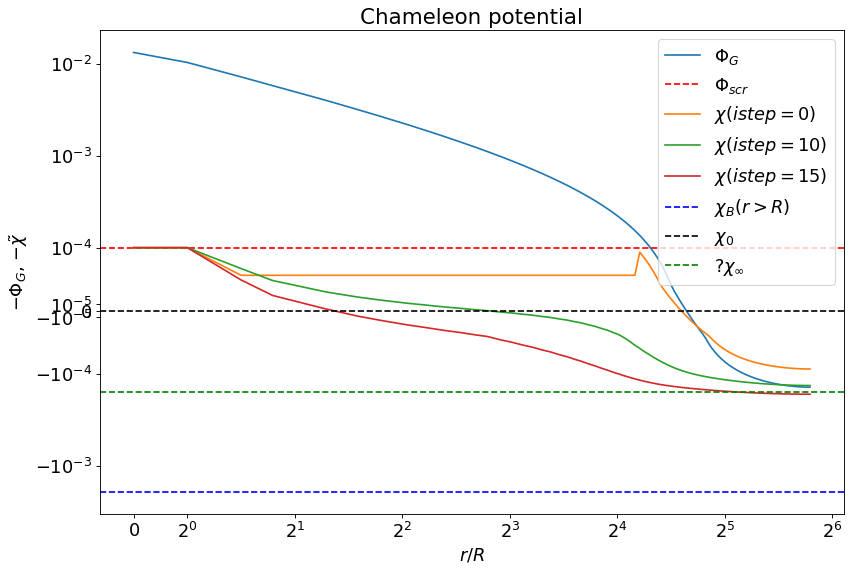

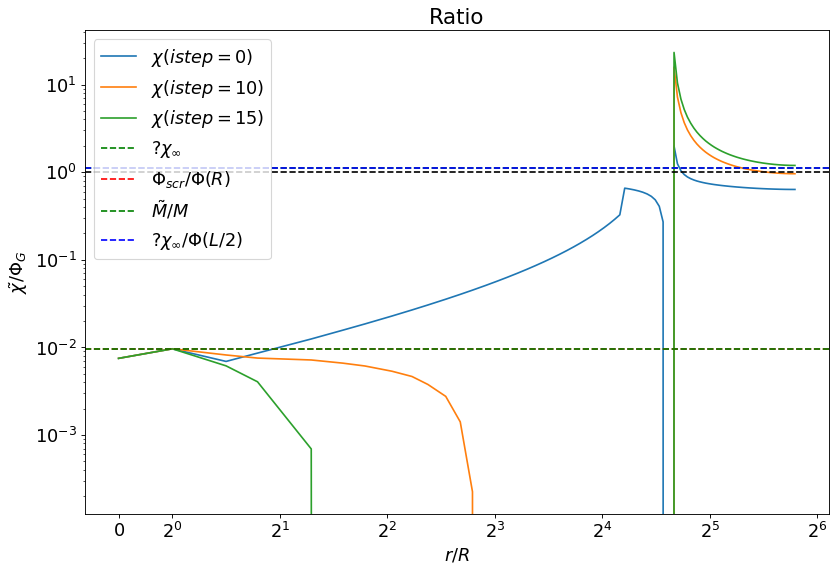

In [65]:
r, pot, chi_all = load_chi()
plot_chi(r, pot, chi_all)
plot_chi_pot_diff(r, chi_all, pot)

In [64]:
rho_b

-0.776811079545455